In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn import preprocessing
pd.options.display.max_columns=999

In [56]:
df_name='df_car_poly_merge.csv'
sub_name='sub_car_poly_merge_id.csv'
df=pd.read_csv(df_name)
df.head()

,acceleration,cylinders,displacement,horsepower,id,model year,mpg,origin,weight,car0_amc,car0_audi,car0_bmw,car0_buick,car0_cadillac,car0_capri,car0_chevroelt,car0_chevrolet,car0_chevy,car0_chrysler,car0_datsun,car0_dodge,car0_fiat,car0_ford,car0_hi,car0_honda,car0_maxda,car0_mazda,car0_mercedes,car0_mercedes-benz,car0_mercury,car0_nissan,car0_oldsmobile,car0_opel,car0_peugeot,car0_plymouth,car0_pontiac,car0_renault,car0_saab,car0_subaru,car0_toyota,car0_toyouta,car0_triumph,car0_vokswagen,car0_volkswagen,car0_volvo,car0_vw,car1_'cuda,car1_100,car1_100ls,car1_1131,car1_12,car1_1200,car1_1200d,car1_124,car1_124b,car1_128,car1_12tl,car1_131,car1_144ea,car1_145e,car1_18i,car1_1900,car1_200-sx,car1_2002,car1_200sx,car1_210,car1_240d,car1_244dl,car1_245,car1_264gl,car1_280-zx,car1_280s,car1_304,car1_310,car1_320i,car1_4000,car1_411,car1_5,car1_5000,car1_5000s,car1_504,car1_505s,car1_510,car1_604sl,car1_610,car1_626,car1_710,car1_810,car1_99e,car1_99gle,car1_99le,car1_accord,car1_ambassador,car1_aries,car1_arrow,car1_aspen,car1_astro,car1_b-210,car1_b210,car1_bel,car1_benz,car1_c10,car1_c20,car1_camaro,car1_capri,car1_caprice,car1_carina,car1_catalina,car1_cavalier,car1_celica,car1_century,car1_challenger,car1_champ,car1_charger,car1_chevelle,car1_chevette,car1_citation,car1_civic,car1_colt,car1_concord,car1_concours,car1_cordoba,car1_corolla,car1_corona,car1_coronet,car1_cougar,car1_country,car1_cressida,car1_cricket,car1_custom,car1_cutlass,car1_d100,car1_d200,car1_dart,car1_dasher,car1_delta,car1_diesel,car1_diplomat,car1_dl,car1_duster,car1_eldorado,car1_electra,car1_escort,car1_estate,car1_f-10,car1_f108,car1_f250,car1_fairmont,car1_fiesta,car1_firebird,car1_fox,car1_fury,car1_futura,car1_galaxie,car1_glc,car1_gran,car1_granada,car1_grand,car1_gremlin,car1_horizon,car1_hornet,car1_ii,car1_impala,car1_j2000,car1_jetta,car1_lebaron,car1_lecar,car1_lemans,car1_lesabre,car1_ltd,car1_lynx,car1_magnum,car1_malibu,car1_manta,car1_mark,car1_marquis,car1_matador,car1_maverick,car1_model,car1_monaco,car1_monarch,car1_monte,car1_monza,car1_mustang,car1_new,car1_newport,car1_nova,car1_omega,car1_omni,car1_opel,car1_pacer,car1_phoenix,car1_pickup,car1_pinto,car1_pl510,car1_prelude,car1_rabbit,car1_rampage,car1_ranger,car1_rebel,car1_regal,car1_reliant,car1_rx-4,car1_rx-7,car1_rx2,car1_rx3,car1_s-10,car1_safari,car1_sapporo,car1_satellite,car1_scirocco,car1_seville,car1_skyhawk,car1_skylark,car1_spirit,car1_st.,car1_stanza,car1_starfire,car1_starlet,car1_strada,car1_sunbird,car1_super,car1_tercel,car1_thunderbird,car1_torino,car1_tr7,car1_type,car1_valiant,car1_vega,car1_ventura,car1_vista,car1_volare,car1_woody,car1_x1.9,car1_zephyr,car2_(auto),car2_(diesel),car2_(man),car2_(sw),car2_111,car2_1200,car2_1300,car2_1500,car2_1600,car2_2+2,car2_2-door,car2_2.2,car2_2000,car2_225,car2_2300,car2_2h,car2_3,car2_300d,car2_320,car2_340,car2_350,car2_4,car2_4w,car2_500,car2_6,car2_88,car2_air,car2_beetle,car2_brougham,car2_c,car2_carlo,car2_ciera,car2_classic,car2_cobra,car2_concours,car2_coupe,car2_cruiser,car2_custom,car2_cvcc,car2_d/l,car2_deluxe,car2_dl,car2_dpl,car2_fury,car2_futura,car2_ghia,car2_gl,car2_gran,car2_gs,car2_gt,car2_gtl,car2_gx,car2_hardtop,car2_hatchback,car2_ii,car2_iii,car2_isuzu,car2_l,car2_landau,car2_liftback,car2_limited,car2_lj,car2_ls,car2_luxus,car2_lx,car2_m/m,car2_malibu,car2_mark,car2_marquis,car2_maxima,car2_medallion,car2_miser,car2_mpg,car2_premier,car2_prix,car2_regis,car2_royal,car2_runabout,car2_salon,car2_se,car2_sebring,car2_sj,car2_special,car2_sport,car2_sportabout,car2_squire,car2_sst,car2_suburb,car2_supreme,car2_sx,car2_tc,car2_tc3,car2_tercel,car2_torino,car2_town,car2_turbo,car2_v6,car2_wagon,car2_xe,car2_yorker,car0_1_amcambassador,car0_1_amcconcord,car0_1_amcgremlin,car0_1_amchornet,car0_1_amcmatador,car0_1_amcpacer,car0_1_amcrebel,car0_1_amcspirit,car0_1_audi100,car0_1_audi100ls,car0_1_audi4000,car0_1_audi5000,car0_1_audi5000s,car0_1_audifox,car0_1_bmw2002,car0_1_bmw320i,car0_1_buickcentury,car0_1_bu

In [57]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [58]:
train_df=df[df['mpg'].notnull()]
test_df=df[df['mpg'].isnull()]
feats=[f for f in train_df.columns if f not in ['id','mpg']]
feats=[f for f in train_df.columns if f not in ['mpg']]

In [59]:
score=np.empty(10)
feature_importance_df = pd.DataFrame()
folds=KFold(n_splits=10,shuffle=True,random_state=0)
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats],train_df['mpg'])):
    train_X,train_y=train_df[feats].iloc[train_idx],train_df['mpg'].iloc[train_idx]
    valid_X,valid_y=train_df[feats].iloc[valid_idx],train_df['mpg'].iloc[valid_idx]
    
    gbm_reg=lgb.LGBMRegressor(objective='regression',
                         num_leaves=31,
                         n_estimators=100)
    gbm_reg.fit(train_X,train_y,
               verbose=0)
    pred_y=gbm_reg.predict(valid_X)
    score[n_fold]=mean_absolute_error(pred_y,valid_y)
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = gbm_reg.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
score.mean()

2.1245074949166494

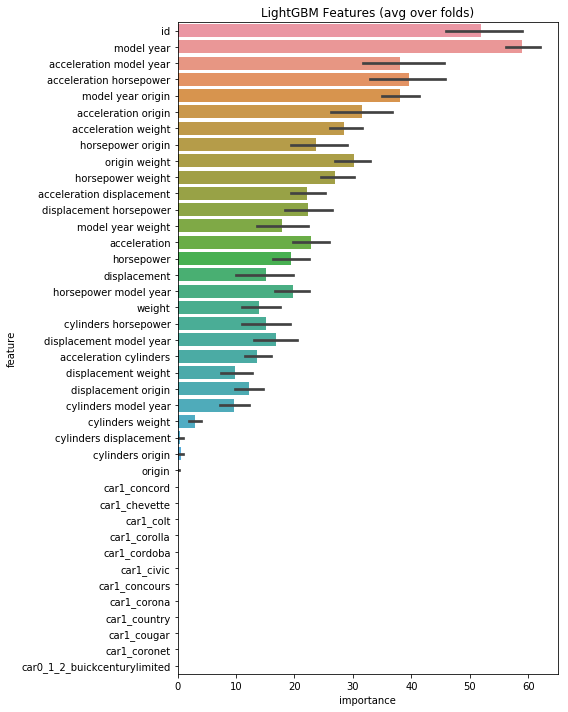

In [60]:
display_importances(feature_importance_df)

In [61]:
#submit
train_X,train_y=train_df[feats],train_df['mpg']
test_X=test_df[feats]
gbm_reg=lgb.LGBMRegressor(objective='regression',
                     num_leaves=31,
                     n_estimators=100)
gbm_reg.fit(train_X,train_y,
           verbose=0)
pred_sub=gbm_reg.predict(test_X)
sub=pd.DataFrame(test_df['id'])
sub['mpg']=pred_sub
sub.to_csv(sub_name,header=False,index=False)